# Lecture 2: Symmetries, entanglement and phase transitions

We will once again be studying the Transverse Field Ising model in 1 Dimension 

$$
H(J,h) = - J \sum_{i} \sigma_i^z\sigma_{i+1}^z -h \sum_i \sigma^x_i 
$$

where J is the anti-ferromagnetic nearest-neighbor coupling, and h is the transverse field.

Today we will leverage what we have learnt about symmetries to push ourselves in realms where we can actually learn something about the physics of those models.

In particular, we will be considering two symmetries: 

- The Parity (or mirror) symmetry, defined as $\hat{P}$, with eigenvalues $\pm 1$ and is otherwise defined as $$\hat{P} |x_1, x_2, \dots, x_N\rangle = |x_N, x_{N-1}, \dots, x_1\rangle$$

- The Translational symmetries $\hat{T}_s$, which has eigenvalues $$k=e^{-i \frac{2\pi}{L} a}$$ and is otherwise defined as
$$\hat{T}_s |x_1, x_2, \dots, x_N\rangle = |x_{1+s}, x_{2+s}, \dots, x_N, x_1, \dots, x_s\rangle$$

To write the Hamiltonian in those basis, we will use a software package called [quspin](https://quspin.github.io/QuSpin/) which allows us to rapidly write the Hamiltonian in a subsector of eigenvalue $a$ or $p$. 
The functions you need to know are the following

- [``quspin.basis.spin_basis_1d``](https://quspin.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html#quspin.basis.spin_basis_1d) to construct the basis for a subsector of the Hilbert space. 
    - This will take an argument `pblock=±1` to specify in which eigen-sector of the parity operator we are
    - And an argument `kblock=a` with $a\in\mathbb{N}$ labelling the momentum subsectors.

-  [``quspin.operator.hamiltonian``](https://quspin.github.io/QuSpin/generated/quspin.operators.hamiltonian.html#quspin.operators.hamiltonian) to build an hamiltonian or an arbitrary operator in a given basis. You wil need to specify 
    - `static_list` the list of 'local' terms appearing in the operator. See the example below.
    - `dynamics_list`, a list of time-dependent terms in the Hamiltonian. Set it to an empty list `[]` for now .
    - `basis`, the basis built above
    - `dtype` the dtype of the hamiltonian. Chose single or double precision depepnding on what precision you need
    - `check_symm=False` and `check_herm=False` to stop quspin from printing too much noisy messages.

A short example could be

```python
from quspin.operators import hamiltonian  # Hamiltonians and operators
from quspin.basis import spin_basis_1d

N = 10
parity_eigenvalue = 1
momentum_subsector = 0

basis = spin_basis_1d(L=N, pblock=parity_eigenvalue, kblock=momentum_subsector)

# Defines the coefficient and the sites on which the zz term acts
J_zz = [[-J, i, (i + 1) % N] for i in range(N)]  # PBC
# Define the field of the local term `h`
h_field = [[-h, i] for i in range(N)]
# define spin static and dynamic lists
static_spin = [["zz", J_zz], ["x", h_field]]  # static part of H

# build spin Hamiltonians
H_spin = hamiltonian(static_spin, [], N=N, basis=basis, dtype=np.float64, check_herm=False, check_symm=False)

# Convert to sparse matrix
H_sparse = H_spin.tocsr()
```


Later on, we will also be computing the 'Bipartite entanglement entropy' between two partitions A and B of the system. This quantity is defined to be
$$
    S(\rho_A) = - \sum_{\psi_A} p^A_{\psi_A} \text{ln} p^A_{\psi_A}
$$
where $p^A_{\psi_A}$ are the eigenvalues and $\psi_A$ the eigenvectors of the reduced density matrix $\rho_A$, defined as 
$$
    \rho_A = \text{Tr}_B[|\psi\rangle\langle\psi|]
$$
or alternatively
$$
    \langle a | \rho_A | a'\rangle = \sum_b  \langle a b | \rho | a' b\rangle
$$

If you do not want to implement this yourself, you can use [`spin_basis_1d.partial_trace(psi, sites_A)`](https://quspin.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html#quspin.basis.spin_basis_1d.partial_trace), where `sites_A` is a list of sites in the partition to be kept.

## Tasks

The tasks that you should solve are the following:
  
  1. First, make a reasonable guess based on your understanding of physics of in which momentum and parity subsector the ground-state must lie. Note it down for later.

  2. Numerically identify the eigenvalue subsector where the ground-state lies. To do this you can compute at fixed system size N and magnetic field $h$ the ground-state energy in each momentum and parity subsector, plot it, and draw some conclusion from that. You can also try to see if this changes by varying $h$. Does it?
      - is this consistent with your prediction?
      - For now, let's fix ourselves in the subsector you have identified.

  3. Compute the total magnetization of the ground-state in this subsector as a function of $h$. Identify like last week the smallest field $h$ at which the total magnetization along the z axis is larger than some threshold value (e.g. 1e-5). Plot how this quantity depends on the system size. What do you think is happening? What do you expect to happen for an infinitely large system?

  4. Now compute the correlation functions defined as $$\langle ZZ\rangle(r) = \langle\sigma^z_0\sigma^z_{r}\rangle - \langle\sigma^z_0\rangle\langle\sigma^z_r\rangle$$ , for different values of $r$, at different magnetic fields $h$ and at a fixed system size $N$ (take at least N=20)
      - You can and should do this calculation analytically, with pen and paper, for $h=0$
      - What can you say about this correlation function? Extract a correlation length $\chi$ such that $\langle ZZ\rangle(r)\approx \alpha e^{-\chi r}$. Plot the correlation length $\chi(h)$ as a function of the transverse field.
      - Now performa finite-size scaling of $\chi(h)$ by plotting in the same figure the value of $\chi_L(h)$ for different system sizes $L$. What can you learn?

  5. Now compute the bipartite entanglement entropy of your ground-state for different values of $h$ and system sizes $L$. 
      - First fix a system size $L=16$ and pick two bipartitions A=[0...8[ and B=[8,16[, and compute it for different values of $h$. For which value of $h$ is the entanglement maximal?
      - Then, compute the bipartite entanglement entropy for diffrent system sizes $L$, and plot the maxmimum entanglement entropy for each system size.  

In [1]:
import numpy as np
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d


def ising_hamiltonian_quspin(N, J, h, parity_eigenvalue=1,
                             momentum_subsector=0):
    basis = spin_basis_1d(L=N, pblock=parity_eigenvalue,
                          kblock=momentum_subsector)

    # Defines the coefficient and the sites on which the zz term acts
    J_zz = [[-J, i, (i + 1) % N] for i in range(N)]  # PBC
    # Define the field of the local term `h`
    h_field = [[-h, i] for i in range(N)]
    # define spin static and dynamic lists
    static_spin = [["zz", J_zz], ["x", h_field]]  # static part of H

    # build spin Hamiltonians
    H_spin = hamiltonian(static_spin, [], N=N, basis=basis, dtype=np.float64,
                         check_herm=False, check_symm=False)

    # Convert to sparse matrix
    return H_spin.tocsr()


def magnetization_quspin(N, parity_eigenvalue=1, momentum_subsector=0):
    basis = spin_basis_1d(L=N, pblock=parity_eigenvalue,
                          kblock=momentum_subsector)
    mz = [[1.0, i] for i in range(N)]
    mz_op = hamiltonian([["z", mz]], [], N=N, basis=basis, dtype=np.float64,
                        check_herm=False, check_symm=False)
    return mz_op.tocsr()

In [2]:
import scipy as sp
from tqdm import tqdm


def calculate_ising_magnetization(N: int, J: float, h_vals: np.ndarray,
                                  parity_eigenvalue=1, momentum_subsector=0
                                  ) -> tuple[np.ndarray, np.ndarray]:
    Mz = magnetization_quspin(N)
    Mz_vals = np.empty_like(h_vals)

    for i, h in tqdm(enumerate(h_vals)):
        H = ising_hamiltonian_quspin(N, J, h, parity_eigenvalue,
                                     momentum_subsector)
        _, v = sp.sparse.linalg.eigsh(H, k=1, which="SA")
        Mz_vals[i] = np.squeeze(v.T @ Mz @ v)
    
    return Mz_vals


def calculate_ising_energy(N: int, J: float, h_vals: np.ndarray,
                           parity_eigenvalue=1, momentum_subsector=0
                           ) -> tuple[np.ndarray, np.ndarray]:
    E_vals = np.empty_like(h_vals)

    for i, h in tqdm(enumerate(h_vals)):
        H = ising_hamiltonian_quspin(N, J, h, parity_eigenvalue,
                                     momentum_subsector)
        w, _ = sp.sparse.linalg.eigsh(H, k=1, which="SA")
        E_vals[i] = w[0]
    
    return E_vals

Since the ground state consists of symmetric vectors, we know for a fact that the ground state is in the parity subsector with eigenvalue 1. Also, the first momentum subsector corresponds to zero momentum, and therefore should give a lower energy, intuitively speaking.

100it [01:06,  1.51it/s]
100it [01:09,  1.43it/s]


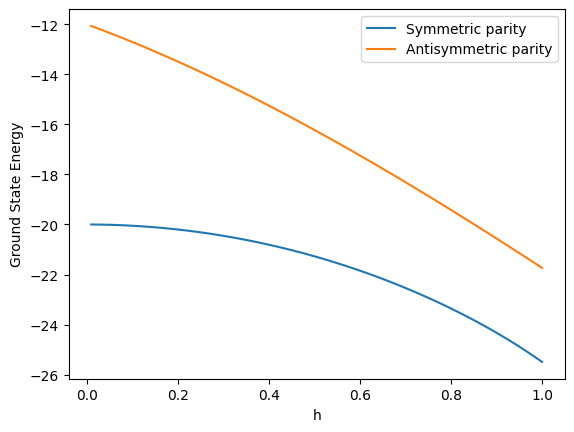

In [24]:
import matplotlib.pyplot as plt


h_vals = np.linspace(0.01, 1, 100)
E_vals_symmetric_parity = calculate_ising_energy(
    20, 1, h_vals, parity_eigenvalue=1)
E_vals_antisymmetric_parity = calculate_ising_energy(
    20, 1, h_vals, parity_eigenvalue=-1)
plt.plot(h_vals, E_vals_symmetric_parity, label='Symmetric parity')
plt.plot(h_vals, E_vals_antisymmetric_parity, label='Antisymmetric parity')
plt.xlabel("h")
plt.ylabel("Ground State Energy")
plt.legend()
plt.show()

100it [00:00, 437.52it/s]
100it [00:00, 465.51it/s]
100it [00:00, 450.11it/s]
100it [00:00, 426.48it/s]
100it [00:00, 477.28it/s]
100it [00:00, 455.20it/s]
100it [00:00, 468.80it/s]
100it [00:00, 477.65it/s]


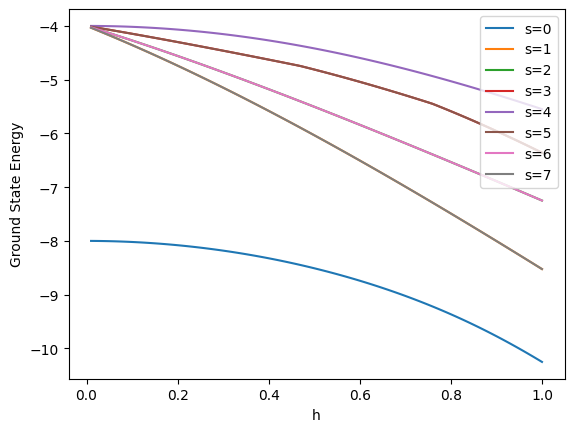

In [81]:
h_vals = np.linspace(0.01, 1, 100)
for momentum_subsector in range(8):
    E_vals = calculate_ising_energy(
        8, 1, h_vals, momentum_subsector=momentum_subsector)
    plt.plot(h_vals, E_vals,
             label=f's={momentum_subsector}')
plt.xlabel("h")
plt.ylabel("Ground State Energy")
plt.legend(loc='upper right')
plt.show()

Obviously, our hypothesis about the ground state being in the first subsector is true.

100it [00:00, 320.49it/s]
100it [00:00, 257.69it/s]
100it [00:00, 190.74it/s]
100it [00:00, 130.68it/s]
100it [00:01, 72.03it/s]
100it [00:02, 43.49it/s]
100it [00:04, 23.36it/s]
100it [00:07, 12.69it/s]
100it [00:15,  6.43it/s]
100it [00:36,  2.78it/s]
100it [01:09,  1.43it/s]


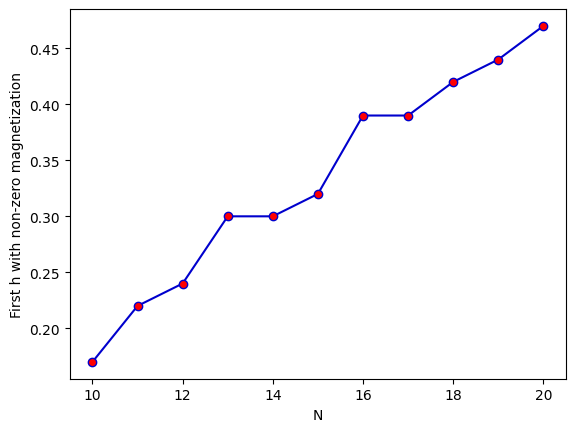

In [15]:
import matplotlib.pyplot as plt


h_nonzero_mz = np.empty(11)
for N in range(10, 21):
    h_vals = np.linspace(0.01, 1, 100)
    mz_vals = calculate_ising_magnetization(N, 1.0, h_vals)
    h_nonzero_mz[N-10] = h_vals[np.max(np.argwhere(np.abs(mz_vals) > 1e-5))]
plt.plot(range(10, 21), h_nonzero_mz, 'o-', c="mediumblue", mfc="red")
plt.xlabel('N')
plt.ylabel("First h with non-zero magnetization")
plt.show()

We observe that the h of non-zero magnetization increases roughly linearly with system size.

In [3]:
def sigma_z_quspin(N, site, parity_eigenvalue=1, momentum_subsector=0):
    basis = spin_basis_1d(L=N, pblock=parity_eigenvalue,
                          kblock=momentum_subsector)
    sz = [[1.0, site]]
    sz_op = hamiltonian([["z", sz]], [], N=N, basis=basis, dtype=np.float64,
                        check_herm=False, check_symm=False)
    return sz_op.tocsr()


def sigma_zz_quspin(N, site1, site2, parity_eigenvalue=1, momentum_subsector=0):
    basis = spin_basis_1d(L=N, pblock=parity_eigenvalue,
                          kblock=momentum_subsector)
    szz = [[1.0, site1, site2]]
    szz_op = hamiltonian([["zz", szz]], [], N=N, basis=basis, dtype=np.float64,
                         check_herm=False, check_symm=False)
    return szz_op.tocsr()

In [4]:
def calculate_ising_correlation(N: int, J: float, h: float, r_vals: np.ndarray,
                                parity_eigenvalue=1, momentum_subsector=0
                                ) -> tuple[np.ndarray, np.ndarray]:
    sz_0 = sigma_z_quspin(N, 0)
    C_vals = np.empty_like(r_vals, dtype=float)

    H = ising_hamiltonian_quspin(N, J, h, parity_eigenvalue,
                                 momentum_subsector)
    _, v = sp.sparse.linalg.eigsh(H, k=1, which="SA")
    for i, r in tqdm(enumerate(r_vals)):
        sz_r = sigma_z_quspin(N, r % N, parity_eigenvalue,
                              momentum_subsector)
        szz_0_r = sigma_zz_quspin(N, 0, r % N, parity_eigenvalue,
                                  momentum_subsector)
        C_vals[i] = np.squeeze((v.T @ szz_0_r @ v)
                               - (v.T @ sz_0 @ v) * (v.T @ sz_r @ v))

    return C_vals

18it [00:07,  2.30it/s]


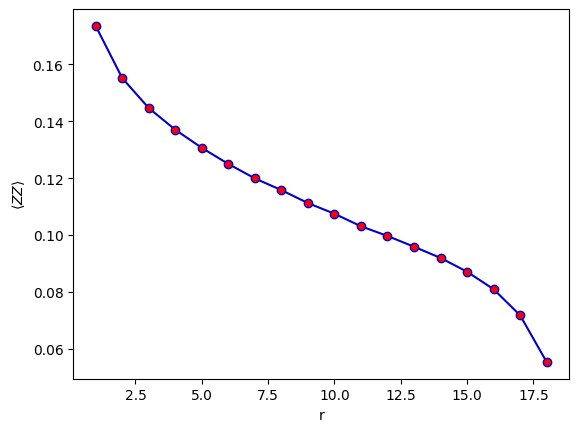

In [24]:
import matplotlib.pyplot as plt

rs = np.arange(1, 19)
correlation = calculate_ising_correlation(20, 1, 1, rs)
plt.plot(rs, correlation, 'o-', c="mediumblue", mfc="red")
plt.xlabel('r')
plt.ylabel(r"$\langle ZZ \rangle$")
plt.show()

The autocorrelation for $r > N/2$ does not give any new information, because of periodic boundary conditions.

5it [00:00, 467.81it/s]


5it [00:00, 376.88it/s]
5it [00:00, 425.03it/s]
5it [00:00, 513.22it/s]
5it [00:00, 405.16it/s]
5it [00:00, 459.98it/s]
5it [00:00, 555.08it/s]
5it [00:00, 542.07it/s]
5it [00:00, 511.21it/s]
5it [00:00, 465.06it/s]
5it [00:00, 456.96it/s]
5it [00:00, 425.73it/s]
5it [00:00, 420.30it/s]
5it [00:00, 452.50it/s]
5it [00:00, 427.08it/s]
5it [00:00, 341.06it/s]
5it [00:00, 391.05it/s]
5it [00:00, 356.16it/s]
5it [00:00, 439.58it/s]
5it [00:00, 355.75it/s]
6it [00:00, 329.41it/s]
6it [00:00, 329.84it/s]
6it [00:00, 325.14it/s]
6it [00:00, 338.77it/s]
6it [00:00, 281.34it/s]
6it [00:00, 305.66it/s]
6it [00:00, 274.98it/s]
6it [00:00, 294.87it/s]
6it [00:00, 285.79it/s]
6it [00:00, 274.15it/s]
6it [00:00, 197.21it/s]
6it [00:00, 250.35it/s]
6it [00:00, 216.67it/s]
6it [00:00, 241.31it/s]
6it [00:00, 227.86it/s]
6it [00:00, 219.04it/s]
6it [00:00, 223.35it/s]
6it [00:00, 225.39it/s]
6it [00:00, 223.13it/s]
6it [00:00, 229.15it/s]
7it [00:00, 130.76it/s]
7it [00:00, 145.27it/s]
7it [00:00, 142

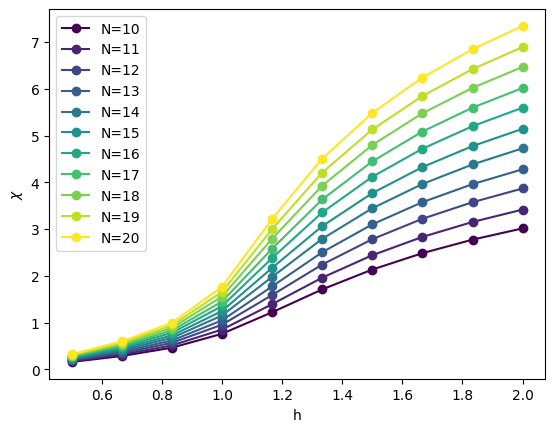

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Ns = range(10, 21)
hs = np.linspace(0.5, 2, 10)
correlation_exponents = np.empty((len(Ns), len(hs)), dtype=float)
for (i, N) in enumerate(Ns):
    rs = np.arange(1, N//2 + 1)
    for j, h in enumerate(hs):
        correlation = calculate_ising_correlation(N, 1, h, rs)
        correlation_exponents[i, j] = -np.polyfit(
            rs, np.log(correlation), 1)[1]
    plt.plot(hs, correlation_exponents[i], 'o-',
             c=mpl.cm.viridis((N - 10) / 10), label=f'N={N}')

plt.xlabel('h')
plt.ylabel(r"$\chi$")
plt.legend()
plt.show()

In [51]:
def calculate_ising_ent_entropy(
        N: int, J: float, h_vals: np.ndarray,
        parity_eigenvalue=1, momentum_subsector=0
        ) -> tuple[np.ndarray, np.ndarray]:
    ent_entropies = np.empty_like(h_vals, dtype=float)
    for i, h in tqdm(enumerate(h_vals)):
        H = ising_hamiltonian_quspin(N, J, h, parity_eigenvalue,
                                     momentum_subsector)
        _, v = sp.sparse.linalg.eigsh(H, k=1, which="SA")
        ent_entropies[i] = spin_basis_1d(
            L=N, pblock=parity_eigenvalue, kblock=momentum_subsector
            ).ent_entropy(v.squeeze(), sparse=True)["Sent_A"]
    return ent_entropies

0it [00:00, ?it/s]

20it [00:07,  2.50it/s]


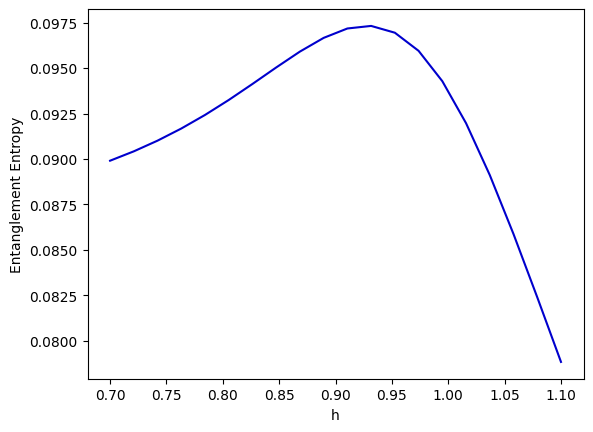

In [55]:
import matplotlib.pyplot as plt


N = 16
h_vals = np.linspace(0.7, 1.1, 20)
ent_entropies = calculate_ising_ent_entropy(N, 1, h_vals)
plt.plot(h_vals, ent_entropies, c="mediumblue")
plt.xlabel('h')
plt.ylabel('Entanglement Entropy')
plt.show()

0it [00:00, ?it/s]

20it [00:00, 72.27it/s]
20it [00:00, 54.53it/s]
20it [00:00, 37.51it/s]
20it [00:00, 26.44it/s]
20it [00:01, 18.25it/s]
20it [00:02,  8.98it/s]
20it [00:04,  4.33it/s]


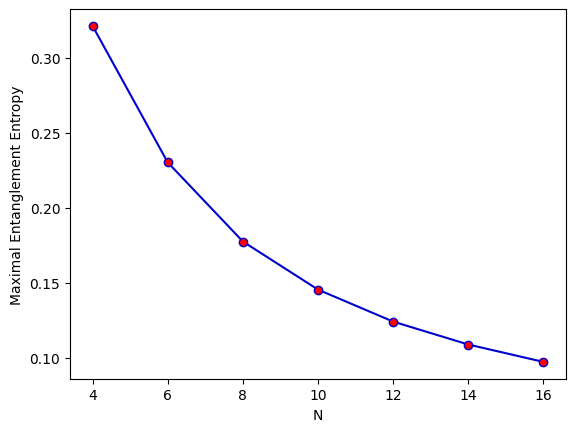

In [64]:
Ns = range(4, 18, 2)
h_vals = np.linspace(0.7, 1.1, 20)
maximal_entanglements = np.empty_like(Ns, dtype=float)
for i, N in enumerate(Ns):
    ent_entropies = calculate_ising_ent_entropy(N, 1, h_vals)
    maximal_entanglements[i] = np.max(ent_entropies)
plt.plot(Ns, maximal_entanglements, 'o-', c="mediumblue", mfc="red")
plt.xlabel('N')
plt.ylabel('Maximal Entanglement Entropy')
plt.show()